#Soccer Analytics Project
Using Machine Learning techniques, our team has created a strategic tool for lower budget soccer clubs to predict the likelihood of a goal being scored given data regarding specific events at the time of a shot. This metric that we are calculating is commonly known in the soccer world as Expected Goal (xG). The model feeds a GUI which allows the user to input different inputs.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, FunctionTransformer, MinMaxScaler

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import ast
from sklearn.feature_selection import SelectKBest, chi2
import math
from sklearn import preprocessing




In [ ]:
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
soccer_data = pd.read_csv("/content/drive/My Drive/shotoutcome_featureeng.csv")

soccer_data.head(40)

,Unnamed: 0,statsbomb_xg,end_location,freeze_frame,player_position,first_time,aerial_won,deflected,open_goal,saved_off_target,saved_to_post,redirect,follows_dribble,kick_off,shot_outcome,shot_technique,shot_type,shot_body
0,0,0.021567,"[116.9, 41.6, 2.2]","[{'location': [89.6, 38.9], 'player': {'id': 6...","[99.2, 55.9]",0,0,0,0,0,0,0,0,0,Saved,Normal,Open Play,Right Foot
1,1,0.018274,"[120.0, 44.7, 3.1]","[{'location': [117.2, 38.6], 'player': {'id': ...","[94.5, 25.1]",0,0,0,0,0,0,0,0,0,Off T,Normal,Open Play,Left Foot
2,2,0.016565,"[99.1, 31.3]","[{'location': [102.7, 32.4], 'player': {'id': ...","[95.3, 27.2]",0,0,0,0,0,0,0,0,0,Wayward,Normal,Open Play,Right Foot
3,3,0.036084,"[120.0, 36.9, 0.3]","[{'location': [108.8, 43.1], 'player': {'id': ...","[106.0, 33.1]",1,0,0,0,0,0,0,0,0,Goal,Half Volley,Open Play,Right Foot
4,4,0.060245,"[120.0, 35.8, 3.8]","[{'location': [109.7, 36.0], 'player': {'id': ...","[108.1, 66.8]",1,0,0,0,0,0,0,0,0,Off T,Normal,Open Play,Left Foot
5,5,0.043244,"[120.0, 45.2, 2.0]","[{'location': [100.3, 43.2], 'player': {'id': ...","[95.1, 43.6]",1,0,0,0,0,0,0,0,0,Off T,Normal,Open Play,Right Foot
6,6,0.042242,"[119.9, 43.4, 2.8]","[{'location': [108.2, 34.4], 'player': {'id': ...","[98.0, 57.4]",0,0,0,0,0,0,0,0,0,Post,Normal,Free Kick,Left Foot
7,7,0.049500,"[104.0, 32.9]","[{'location': [116.8, 37.9], 'player': {'id': ...","[102.0, 31.2]",0,0,0,0,0,0,0,0,0,Blocked,Normal,Open Play,Left Foot
8,8,0.098546,"[109.2, 46.8, 1.8]","[{'location': [64.6, 57.9], 'player': {'id': 6...","[77.5, 78.1]",0,0,0,0,0,0,0,0,0,Saved,Lob,Open Play,Right Foot
9,9,0.034409,"[120.0, 43.8, 3.5]","[{'location': [118.5, 40.3], 'player': {'id': ...","[90.7, 39.0]",0,0,0,0,0,0,0,0,0,Off T,Normal,Free Kick,Left Foot


# Data Cleaning and Feature Engineering
- Created a distance from goal feature from the x and y positions
- Consolidated Right Foot and Left Foot to simply Foot as a shot body type feature.
- Filtered data to only include "Open Play" shots



In [ ]:
soccer_data["player_position"] = soccer_data["player_position"].apply(ast.literal_eval)

def feet(x):
  if x == "Right Foot" or x == "Left Foot":
    return "Foot"
  else:
    return x
soccer_data["shot_body"] = soccer_data["shot_body"].apply(feet)

In [ ]:
shot_types = pd.get_dummies(soccer_data["shot_type"])
shot_techniques = pd.get_dummies(soccer_data["shot_technique"])
shot_outcomes = pd.get_dummies(soccer_data["shot_outcome"])

shot_body = pd.get_dummies(soccer_data["shot_body"])
soccer_data["x_pos"] = soccer_data["player_position"].apply(lambda x: x[0])
soccer_data["y_pos"] = soccer_data["player_position"].apply(lambda x: x[1])


In [ ]:
shot_body

,Foot,Head,Other
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
22679,1,0,0
22680,0,1,0
22681,1,0,0
22682,0,1,0


In [ ]:
data = pd.concat([soccer_data, shot_types, shot_techniques, shot_outcomes, shot_body], axis = 1)
data = data[data["shot_type"] != "Penalty"]
np.mean(data[data["shot_outcome"] == "Goal"]["end_location"].apply(ast.literal_eval).apply(lambda x: x[1]))
data["distance"] = np.sqrt((data["x_pos"] - 120)**2 + (data["y_pos"] - 40.1)**2) # 40.1 is the median of y values from goals scored
data[data["Saved to Post"] == 1]
#end_x = data["end_location"].apply(lambda x: x[1])
#np.mean(end_x)

,Unnamed: 0,statsbomb_xg,end_location,freeze_frame,player_position,first_time,aerial_won,deflected,open_goal,saved_off_target,saved_to_post,redirect,follows_dribble,kick_off,shot_outcome,shot_technique,shot_type,shot_body,x_pos,y_pos,Corner,Free Kick,Kick Off,Open Play,Penalty,Backheel,Diving Header,Half Volley,Lob,Normal,Overhead Kick,Volley,Blocked,Goal,Off T,Post,Saved,Saved Off Target,Saved to Post,Wayward,Foot,Head,Other,distance
215,215,0.169158,"[118.1, 40.7, 2.3]","[{'location': [103.4, 45.9], 'player': {'id': ...","[112.3, 42.2]",0,0,0,0,0,1,0,0,0,Saved to Post,Normal,Open Play,Head,112.3,42.2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,7.981228
235,235,0.074978,"[118.0, 32.9, 1.8]","[{'location': [117.8, 33.4], 'player': {'id': ...","[117.4, 29.6]",0,0,0,0,0,1,0,0,0,Saved to Post,Half Volley,Open Play,Foot,117.4,29.6,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,10.817116
515,515,0.127620,"[118.0, 38.0, 2.0]","[{'location': [117.0, 44.0], 'player': {'id': ...","[114.0, 35.0]",1,0,0,0,0,1,0,0,0,Saved to Post,Normal,Open Play,Foot,114.0,35.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,7.874643
1500,1500,0.062350,"[120.0, 37.6, 1.3]","[{'location': [119.7, 39.6], 'player': {'id': ...","[113.0, 17.3]",0,0,0,0,0,1,0,0,0,Saved to Post,Normal,Free Kick,Foot,113.0,17.3,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,23.850367
1556,1556,0.156052,"[118.9, 37.5, 0.3]","[{'location': [118.8, 39.1], 'player': {'id': ...","[104.1, 39.0]",1,0,0,0,0,1,0,0,0,Saved to Post,Normal,Open Play,Foot,104.1,39.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,15.938005
1664,1664,0.060168,"[119.0, 42.7, 2.4]","[{'location': [113.2, 37.6], 'player': {'id': ...","[101.2, 47.8]",1,0,0,0,0,1,0,0,0,Saved to Post,Normal,Open Play,Foot,101.2,47.8,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,20.315757
1881,1881,0.084522,"[119.0, 39.6, 2.4]","[{'location': [119.6, 39.6], 'player': {'id': ...","[110.6, 36.4]",0,0,0,0,0,1,0,0,0,Saved to Post,Normal,Open Play,Head,110.6,36.4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,10.101980
2069,2069,0.027799,"[118.9, 37.2, 2.4]","[{'location': [102.0, 33.9], 'player': {'id': ...","[91.6, 30.9]",0,0,0,0,0,1,0,0,0,Saved to Post,Normal,Free Kick,Foot,91.6,30.9,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,29.852973
2504,2504,0.105071,"[111.4, 37.0, 0.4]","[{'location': [98.2, 28.4], 'player': {'id': 4...","[99.2, 27.7]",0,0,0,0,0,1,0,0,0,Saved to Post,Half Volley,Open Play,Foot,99.2,27.7,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,24.215697
2555,2555,0.111915,"[119.3, 36.2, 0.2]","[{'location': [88.0, 11.6], 'player': {'id': 5...","[117.3, 30.3]",1,0,0,0,0,1,0,0,0,Saved to Post,Normal,Open Play,Foot,117.3,30.3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,10.165136


In [ ]:
game_info = pd.read_csv("/content/drive/My Drive/shotoutcome_wthplayerinfo.csv")
game_info

data["nearby_players"] = game_info["nearby_players"]
data["nearby_players"] = data["nearby_players"].fillna(0)
data["dist_to_center"] = np.abs(data["y_pos"] - 40.1)



Obstructing opponents within shot angle

In [ ]:
with open("/content/drive/My Drive/obstructing.npy", 'rb') as f:
  data["obstructing_players"] = np.load(f)

Shot Angle

In [ ]:
with open("/content/drive/My Drive/angles.npy", 'rb') as f:
  data["angle"] = np.load(f)

For strategic reasons, we considered shots that hit the post or were saved to post as goals given that those are generally good outcomes that can go either way.

In [ ]:
data["goal_block"] = data["Goal"] + data["Post"] + data["Saved to Post"]

def func(i):
  if i != 0 :
    return 1
  return 0
  
data["goal_block"] = data["goal_block"].apply(func)
data = data.sort_values(by = "goal_block", ascending = False)

data = data[data["shot_type"] == "Open Play"]

In [ ]:
data.groupby("shot_body").agg(sum)

,Unnamed: 0,statsbomb_xg,first_time,aerial_won,deflected,open_goal,saved_off_target,saved_to_post,redirect,follows_dribble,kick_off,x_pos,y_pos,Corner,Free Kick,Kick Off,Open Play,Penalty,Backheel,Diving Header,Half Volley,Lob,Normal,Overhead Kick,Volley,Blocked,Goal,Off T,Post,Saved,Saved Off Target,Saved to Post,Wayward,Foot,Head,Other,distance,nearby_players,dist_to_center,obstructing_players,angle,goal_block
shot_body,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Foot,200968945,1958.361554,6042,0,205,212,62,35,52,12,0,1823156.6,703447.7,0.0,0.0,0.0,17705.0,0.0,69.0,0.0,2045.0,299.0,13847.0,123.0,1322.0,4577.0,2093.0,5376.0,386.0,4633.0,62.0,35.0,543.0,17705.0,0.0,0.0,358005.096878,5810.0,158063.8,4625,402281.350045,2514
Head,36924082,331.672386,14,1373,14,46,19,8,17,0,0,356228.9,127646.7,0.0,0.0,0.0,3197.0,0.0,0.0,86.0,0.0,8.0,3095.0,1.0,7.0,327.0,349.0,1349.0,82.0,667.0,19.0,8.0,396.0,0.0,3197.0,0.0,31742.450875,1056.0,12605.6,1286,138905.936034,439
Other,608980,15.832655,26,2,0,6,0,1,5,0,0,6691.5,2412.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,1.0,0.0,58.0,0.0,1.0,10.0,16.0,14.0,0.0,8.0,0.0,1.0,11.0,0.0,0.0,60.0,590.057900,18.0,232.2,23,2961.753614,17


In [ ]:
X = data[["first_time", "obstructing_players","aerial_won",	"redirect",	"follows_dribble",	"nearby_players", "Backheel","Diving Header",	"Half Volley"	,"Lob",	"Normal"	,"Overhead Kick","Volley","Head",	"Foot","distance",	"dist_to_center",	"angle"]]


y = data[["goal_block"]]
pd.concat([X,y],axis = 1).to_csv("soccer_analytics.csv")




In [ ]:
data

,Unnamed: 0,statsbomb_xg,end_location,freeze_frame,player_position,first_time,aerial_won,deflected,open_goal,saved_off_target,saved_to_post,redirect,follows_dribble,kick_off,shot_outcome,shot_technique,shot_type,shot_body,x_pos,y_pos,Corner,Free Kick,Kick Off,Open Play,Penalty,Backheel,Diving Header,Half Volley,Lob,Normal,Overhead Kick,Volley,Blocked,Goal,Off T,Post,Saved,Saved Off Target,Saved to Post,Wayward,Foot,Head,Other,distance,nearby_players,dist_to_center,obstructing_players,angle,goal_block
7057,7057,0.028095,"[120.0, 43.9, 1.0]","[{'location': [110.2, 36.4], 'player': {'id': ...","[107.8, 26.1]",0,0,0,0,0,0,0,0,0,Goal,Normal,Open Play,Foot,107.8,26.1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,18.569868,0.0,14.0,0,16.664571,1
10233,10233,0.212080,"[120.0, 40.6, 1.6]","[{'location': [106.3, 44.5], 'player': {'id': ...","[102.1, 46.4]",1,0,0,0,0,0,0,0,0,Goal,Lob,Open Play,Head,102.1,46.4,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,18.976301,0.0,6.3,0,22.520882,1
2767,2767,0.230922,"[120.0, 43.6, 0.2]","[{'location': [117.8, 35.7], 'player': {'id': ...","[112.9, 29.3]",1,0,0,0,0,0,0,0,0,Goal,Normal,Open Play,Foot,112.9,29.3,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,12.924782,1.0,10.8,0,20.879830,1
13967,13967,0.010922,"[120.0, 37.2, 0.2]","[{'location': [80.7, 41.6], 'player': {'id': 2...","[84.1, 40.2]",0,0,0,0,0,0,0,0,0,Goal,Normal,Open Play,Foot,84.1,40.2,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,35.900139,1.0,0.1,0,12.714207,1
17959,17959,0.347432,"[120.0, 41.2, 0.4]","[{'location': [104.2, 37.0], 'player': {'id': ...","[113.6, 35.3]",1,0,0,0,0,0,0,0,0,Goal,Normal,Open Play,Foot,113.6,35.3,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,8.000000,0.0,4.8,0,47.418365,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8207,8207,0.049654,"[117.3, 40.7, 0.4]","[{'location': [84.8, 52.6], 'player': {'id': 4...","[97.3, 32.7]",0,0,0,0,0,0,0,0,0,Saved,Half Volley,Open Play,Foot,97.3,32.7,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,23.875720,0.0,7.4,0,18.193037,0
8206,8206,0.164168,"[117.8, 37.5, 1.6]","[{'location': [98.6, 49.6], 'player': {'id': 4...","[103.4, 38.7]",1,0,0,0,0,0,0,0,0,Saved,Normal,Open Play,Foot,103.4,38.7,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,16.658932,0.0,1.4,0,26.945242,0
8205,8205,0.075798,"[120.0, 32.0, 0.2]","[{'location': [107.8, 35.3], 'player': {'id': ...","[108.7, 27.4]",1,0,0,0,0,0,0,0,0,Off T,Normal,Open Play,Foot,108.7,27.4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,16.999412,0.0,12.7,0,18.482595,0
8204,8204,0.020787,"[120.0, 28.3, 5.6]","[{'location': [95.4, 41.9], 'player': {'id': 1...","[100.9, 22.6]",0,0,0,0,0,0,0,0,0,Off T,Normal,Open Play,Foot,100.9,22.6,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,25.904826,1.0,17.5,0,13.197215,0


#Heatmap

In [ ]:

dataset = pd.concat([X, y], axis = 1)
dataset.corr()

,first_time,obstructing_players,aerial_won,redirect,follows_dribble,nearby_players,Backheel,Diving Header,Half Volley,Lob,Normal,Overhead Kick,Volley,Head,Foot,distance,dist_to_center,angle,goal_block
first_time,1.000000,0.059695,-0.167692,-0.038053,0.002278,0.011340,0.045843,-0.041034,0.219375,0.018311,-0.373589,0.072682,0.301039,-0.267120,0.262603,-0.116198,-0.096752,0.095983,0.091416
obstructing_players,0.059695,1.000000,0.053620,0.023024,0.018759,-0.007372,0.014635,0.007085,0.013171,-0.023271,-0.029951,0.014514,0.033674,0.084866,-0.085553,-0.222798,0.025458,0.109108,0.021413
aerial_won,-0.167692,0.053620,1.000000,-0.009272,-0.006341,0.009407,-0.015226,0.010125,-0.087138,-0.032302,0.122987,-0.020439,-0.068172,0.623495,-0.617741,-0.267726,-0.200397,0.280117,-0.042998
redirect,-0.038053,0.023024,-0.009272,1.000000,-0.001425,0.005291,0.094877,0.008763,-0.000604,-0.007256,-0.034952,0.016386,0.030702,0.012784,-0.023318,-0.062678,-0.047573,0.103239,0.028866
follows_dribble,0.002278,0.018759,-0.006341,-0.001425,1.000000,0.000210,-0.001375,-0.001536,-0.001151,-0.002918,0.001366,-0.001846,0.001952,-0.010153,0.010265,-0.012384,0.009768,-0.004767,0.007434
nearby_players,0.011340,-0.007372,0.009407,0.005291,0.000210,1.000000,-0.006903,-0.010942,0.008602,0.002246,-0.009290,0.003627,0.006692,0.001438,-0.001028,-0.009308,-0.004214,0.006466,0.000156
Backheel,0.045843,0.014635,-0.015226,0.094877,-0.001375,-0.006903,1.000000,-0.003688,-0.018900,-0.007006,-0.119040,-0.004433,-0.014958,-0.024379,0.024648,-0.061942,-0.031304,0.063404,-0.004242
Diving Header,-0.041034,0.007085,0.010125,0.008763,-0.001536,-0.010942,-0.003688,1.000000,-0.021109,-0.007825,-0.132951,-0.004951,-0.016706,0.151299,-0.149646,-0.067169,-0.048174,0.077136,0.012445
Half Volley,0.219375,0.013171,-0.087138,-0.000604,-0.001151,0.008602,-0.018900,-0.021109,1.000000,-0.040095,-0.681248,-0.025370,-0.085602,-0.139517,0.140615,-0.021059,-0.019697,0.003861,-0.009628
Lob,0.018311,-0.023271,-0.032302,-0.007256,-0.002918,0.002246,-0.007006,-0.007825,-0.040095,1.000000,-0.252536,-0.009405,-0.031732,-0.042882,0.043520,0.027501,0.025089,-0.025387,0.087118


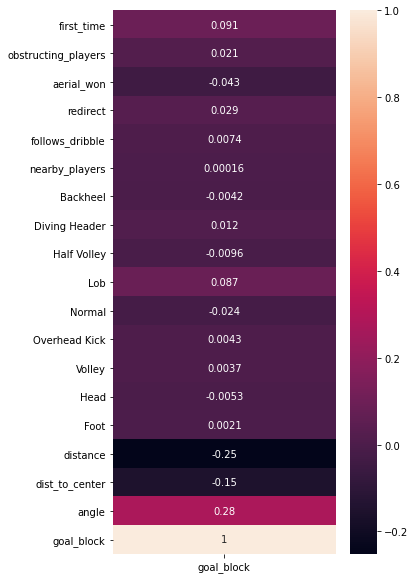

In [ ]:
plt.figure(figsize=(5,10))
sns.heatmap(dataset.corr()[["goal_block"]], annot = True)

In [ ]:
data[data["angle"].isna()]

,Unnamed: 0,statsbomb_xg,end_location,freeze_frame,player_position,first_time,aerial_won,deflected,open_goal,saved_off_target,saved_to_post,redirect,follows_dribble,kick_off,shot_outcome,shot_technique,shot_type,shot_body,x_pos,y_pos,Corner,Free Kick,Kick Off,Open Play,Penalty,Backheel,Diving Header,Half Volley,Lob,Normal,Overhead Kick,Volley,Blocked,Goal,Off T,Post,Saved,Saved Off Target,Saved to Post,Wayward,Foot,Head,Other,distance,nearby_players,dist_to_center,obstructing_players,angle,goal_block


#PCA and Elbow Method

Due to minimal correlations PCA was not useful for our project. Since we decided not to use the K means clustering model, the elbow method was also not useful. This was purely for exploratory purposes.

Text(0, 0.5, 'Fraction of Variance')

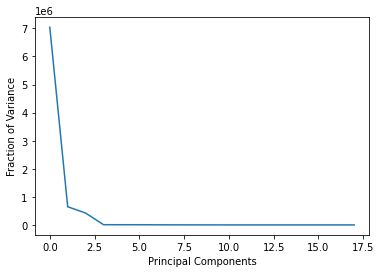

In [ ]:
X_data = X.to_numpy()
target = y.to_numpy()
data_mean = np.mean(X_data, axis =0)
centered_data = X_data - data_mean
u, s, vt = np.linalg.svd(centered_data, full_matrices = False)
plt.plot(s**2)
plt.xlabel("Principal Components")
plt.ylabel("Fraction of Variance")

Text(0, 0.5, 'pc1')

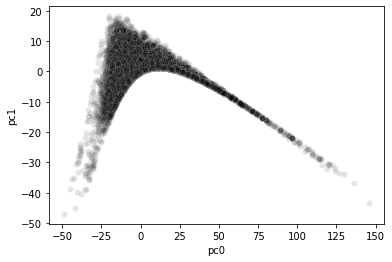

In [ ]:
pcs = u * s
sns.scatterplot(x=pcs[:, 0], y=pcs[:,1], alpha=.1,color = "black");
plt.xlabel("pc0")
plt.ylabel("pc1")


In [ ]:
pd.DataFrame(u*s)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-9.517011,4.108963,-3.620309,-0.319410,0.240066,0.392635,0.212977,0.153777,-0.024059,0.017463,0.014731,0.001055,-0.001659,-0.003208,-0.000031,-0.000127,-0.001129,-1.368733e-14
1,-2.860122,0.739415,2.577116,0.039977,0.105686,0.357114,-1.257712,-0.767654,-0.119165,-0.539800,-1.045927,-0.247891,0.084996,0.024208,-0.009192,-0.010414,0.001289,2.829383e-15
2,-2.920236,7.415172,-1.276288,0.326553,0.689097,-0.482363,0.315312,-0.555767,0.156193,-0.008851,-0.010120,-0.005778,-0.012089,-0.000723,-0.009446,-0.003625,-0.001286,1.609331e-15
3,-17.010398,-11.975123,10.304649,-0.176693,-0.066437,-0.736543,0.120666,0.107033,-0.026309,0.000931,0.007255,0.008775,-0.004595,0.001507,0.003553,0.001005,0.000869,-5.201877e-15
4,24.092879,1.522458,-1.210791,0.405782,0.450200,0.501852,0.544941,-0.399009,0.172293,0.017821,-0.012276,-0.013417,-0.007669,-0.012842,-0.004855,-0.006878,-0.000857,-5.219149e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20957,-8.880165,-2.079894,2.320653,0.419651,0.192067,0.412865,-0.764413,0.794461,0.330595,0.016052,0.084461,-0.012270,0.010798,-0.001156,0.005350,0.002703,-0.000046,-4.510142e-17
20958,2.959035,0.690060,6.420672,0.341917,0.205895,0.422203,0.368617,-0.511095,0.162514,-0.001002,-0.014695,-0.007187,-0.011198,-0.001961,-0.008055,-0.004251,-0.000444,-8.411734e-18
20959,-7.017434,4.748440,-2.709613,0.264653,0.361081,0.458495,0.231978,-0.608840,0.154171,-0.010644,-0.008469,-0.003315,-0.009880,0.001086,-0.009559,-0.003715,-0.001022,-7.943884e-18
20960,-16.142126,-0.993199,-6.467249,-0.263692,0.402629,-0.605215,0.097279,0.076497,-0.030273,0.003593,0.016774,0.007235,-0.001657,-0.001369,0.001928,0.000276,-0.000665,1.100227e-17


In [ ]:
u = u[:, 0:19]
s = s[0:19]
vt = vt[0:19, :]
pd.DataFrame(u[:, 0:19] * s[0:19] @ vt[0:19,:])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.290144,-0.283084,-0.065595,-0.00353,-0.000572,-0.328404,-0.003292,-0.004103,-0.097605,-0.014646,0.189009,-0.005915,-0.063448,-0.152514,0.155376,-0.051332,5.847076,-9.294261
1,0.709856,-0.283084,-0.065595,-0.00353,-0.000572,-0.328404,-0.003292,-0.004103,-0.097605,0.985354,-0.810991,-0.005915,-0.063448,0.847486,-0.844624,0.355100,-1.852924,-3.437950
2,0.709856,-0.283084,-0.065595,-0.00353,-0.000572,0.671596,-0.003292,-0.004103,-0.097605,-0.014646,0.189009,-0.005915,-0.063448,-0.152514,0.155376,-5.696418,2.647076,-5.079002
3,-0.290144,-0.283084,-0.065595,-0.00353,-0.000572,0.671596,-0.003292,-0.004103,-0.097605,-0.014646,0.189009,-0.005915,-0.063448,-0.152514,0.155376,17.278939,-8.052924,-13.244625
4,0.709856,-0.283084,-0.065595,-0.00353,-0.000572,-0.328404,-0.003292,-0.004103,-0.097605,-0.014646,0.189009,-0.005915,-0.063448,-0.152514,0.155376,-10.621201,-3.352924,21.459532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20957,-0.290144,-0.283084,-0.065595,-0.00353,-0.000572,-0.328404,-0.003292,-0.004103,0.902395,-0.014646,-0.810991,-0.005915,-0.063448,-0.152514,0.155376,5.254519,-0.752924,-7.765795
20958,0.709856,-0.283084,-0.065595,-0.00353,-0.000572,-0.328404,-0.003292,-0.004103,-0.097605,-0.014646,0.189009,-0.005915,-0.063448,-0.152514,0.155376,-1.962269,-6.752924,0.986410
20959,0.709856,-0.283084,-0.065595,-0.00353,-0.000572,-0.328404,-0.003292,-0.004103,-0.097605,-0.014646,0.189009,-0.005915,-0.063448,-0.152514,0.155376,-1.621789,4.547076,-7.476237
20960,-0.290144,-0.283084,-0.065595,-0.00353,-0.000572,0.671596,-0.003292,-0.004103,-0.097605,-0.014646,0.189009,-0.005915,-0.063448,-0.152514,0.155376,7.283625,9.347076,-12.761617


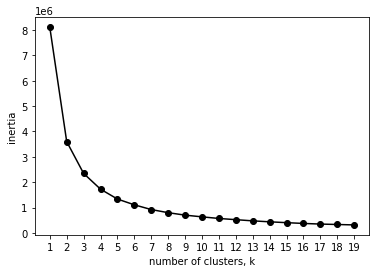

In [ ]:
#understand elbow method
from sklearn.cluster import KMeans
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(pcs[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#elbow at 2~3

In [ ]:
#understand selectKBest
features = SelectKBest(chi2, k=10)
features.fit(X, y)
cols = features.get_support(indices=True)
cols = X.iloc[:,cols]
cols.columns

Index(['first_time', 'obstructing_players', 'aerial_won', 'redirect',
       'Diving Header', 'Lob', 'Normal', 'distance', 'dist_to_center',
       'angle'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


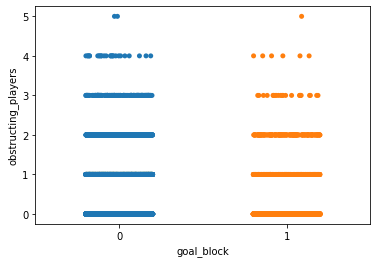

In [ ]:
sns.stripplot(data["goal_block"], data["obstructing_players"] ,jitter=0.2)

0.2779012894619831
0.31447811447811447


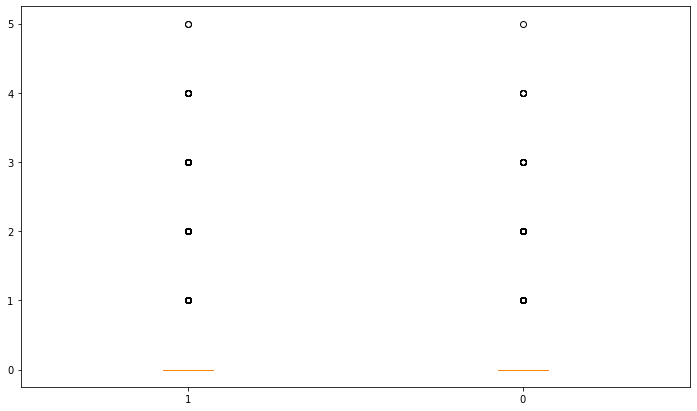

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
labels = data["goal_block"].unique()
dataset = [data[(data["goal_block"] == 0)]["obstructing_players"], data[data["goal_block"] == 1]["obstructing_players"]]
ax.boxplot(dataset, labels=labels)

print(np.mean(data[data["goal_block"] == 0]["obstructing_players"]))
print(np.mean(data[data["goal_block"] == 1]["obstructing_players"]))

#Model Creation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[["angle","obstructing_players","distance","Foot", "Head","first_time", "dist_to_center"]], y, test_size=0.35, random_state=42)
#"first_time","angle",	"obstructing_players","Head",	"Foot"
from scipy.special import expit
XGB = xgb.XGBClassifier(objective = "reg:logistic", learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 7, class_weight = "balanced")

XGB.fit(X_train, y_train)
def logreg_model(x):
    return 1 / (1 + np.exp(-x))

logreg = LogisticRegression(max_iter=1000, class_weight = {1:1.5})                                # instantiate
logreg.fit(X_train, y_train)


from sklearn.externals import joblib

# Save to file in the current working directory
#joblib_file = "soccer_analytics2.pkl"
#joblib.dump(log, joblib_file)
sklearn.metrics.roc_auc_score(y_test,logreg.predict_proba(X_test)[:,1])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7424237466651863

In [ ]:
print(sklearn.metrics.roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))

print(sklearn.metrics.roc_auc_score(y_test, XGB.predict_proba(X_test)[:,1]))

0.7424237466651863
0.7336604981270458


Gridsearch for class_weight hyperparameter. This was used to combat class imbalance.

In [ ]:
from sklearn.model_selection import GridSearchCV
parameter = {'class_weight':[{1: w} for w in [1, 1.5, 2, 2.5, 3]]}
clf = GridSearchCV(logreg, parameter)
clf.fit(X_train, y_train)
print(clf.cv_results_)
#1.5 is an optimal class_weight.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConv

{'mean_fit_time': array([0.1784111 , 0.13530669, 0.14441047, 0.14741483, 0.16920271]), 'std_fit_time': array([0.03535813, 0.01426961, 0.0153638 , 0.03933788, 0.03791295]), 'mean_score_time': array([0.00235171, 0.00217233, 0.00221791, 0.00216951, 0.00217605]), 'std_score_time': array([4.77774804e-04, 6.85327311e-05, 5.17434454e-05, 3.09605046e-05,
       3.48019266e-05]), 'param_class_weight': masked_array(data=[{1: 1}, {1: 1.5}, {1: 2}, {1: 2.5}, {1: 3}],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'class_weight': {1: 1}}, {'class_weight': {1: 1.5}}, {'class_weight': {1: 2}}, {'class_weight': {1: 2.5}}, {'class_weight': {1: 3}}], 'split0_test_score': array([0.8612844 , 0.86275229, 0.85541284, 0.83706422, 0.81651376]), 'split1_test_score': array([0.85761468, 0.85100917, 0.84036697, 0.82568807, 0.80880734]), 'split2_test_score': array([0.86018349, 0.85981651, 0.85284404, 0.84477064, 0.82238532]), 'split3_test_score'

In [ ]:
XGB.predict_proba(X_train)[0:100]

array([[0.60147357, 0.3985264 ],
       [0.7118014 , 0.2881986 ],
       [0.701574  , 0.29842597],
       [0.7286949 , 0.2713051 ],
       [0.74190867, 0.25809136],
       [0.7118014 , 0.2881986 ],
       [0.51903355, 0.48096645],
       [0.701574  , 0.29842597],
       [0.74190867, 0.25809136],
       [0.41450572, 0.5854943 ],
       [0.701574  , 0.29842597],
       [0.60147357, 0.3985264 ],
       [0.7372822 , 0.26271778],
       [0.7118014 , 0.2881986 ],
       [0.72247815, 0.27752182],
       [0.74190867, 0.25809136],
       [0.7176973 , 0.28230268],
       [0.7372822 , 0.26271778],
       [0.67307013, 0.32692987],
       [0.6989715 , 0.30102846],
       [0.60147357, 0.3985264 ],
       [0.701574  , 0.29842597],
       [0.6989715 , 0.30102846],
       [0.62966675, 0.37033325],
       [0.69235337, 0.30764666],
       [0.6666161 , 0.3333839 ],
       [0.62240803, 0.377592  ],
       [0.74190867, 0.25809136],
       [0.74190867, 0.25809136],
       [0.7372822 , 0.26271778],
       [0.

In [ ]:
import plotly.figure_factory as ff
y_pred = logreg.predict(X_test)
df = pd.DataFrame(columns=['threshold','accuracy', 'falses', 'recall'])
df2 = pd.DataFrame(columns=['threshold','accuracy', 'falses', 'recall'])
def Goals(df, name):
    return df[name]
for THRESHOLD in np.linspace(0,1,10, endpoint= False):
  y_pred  = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
  y_pred2 = np.where(XGB.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
  conf = sklearn.metrics.confusion_matrix(y_test, y_pred)
  conf2 = sklearn.metrics.confusion_matrix(y_test, y_pred2)
  FP = conf[0][1]
  TN = conf[0][0]

  FP2 = conf2[0][1]
  TN2 = conf2[0][0]
  fp_rate = FP/(FP+TN)

  fp_rate2 = FP2/(FP2+TN2)

  
  acc = sklearn.metrics.accuracy_score(y_test, y_pred)
  falses = sklearn.metrics.precision_score(y_test, y_pred)
  rec = sklearn.metrics.recall_score(y_test, y_pred)

  acc2 = sklearn.metrics.accuracy_score(y_test, y_pred2)
  rec2 = sklearn.metrics.recall_score(y_test, y_pred2)
  

  df = df.append(pd.DataFrame([[THRESHOLD, acc, fp_rate, rec]], columns = ['threshold','accuracy','falses','recall']), ignore_index = True)
  df2 = df2.append(pd.DataFrame([[THRESHOLD, acc2, fp_rate2, rec2]], columns = ['threshold','accuracy','falses','recall']), ignore_index = True)
  fig = ff.create_annotated_heatmap(z=conf,
                                  x=["False", "True"], y=["False", "True"], 
                                  showscale=True)
  fig.update_layout(font=dict(size=18))
# Add Labels
  fig.add_annotation(x=0,y=0, text="True Negative", 
                   yshift=40, showarrow=False, font=dict(color="black",size=24))
  fig.add_annotation(x=1,y=0, text="False Positive", 
                   yshift=40, showarrow=False, font=dict(color="white",size=24))
  fig.add_annotation(x=0,y=1, text="False Negative", 
                   yshift=40, showarrow=False, font=dict(color="white",size=24))
  fig.add_annotation(x=1,y=1, text="True Positive", 
                   yshift=40, showarrow=False, font=dict(color="white",size=24))

  fig.update_xaxes(title="Predicted")
  fig.update_yaxes(title="Actual", autorange="reversed")
  fig.show()
  
  
  
  
  
 

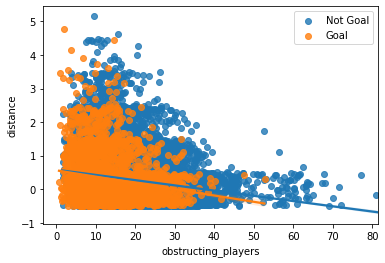

In [ ]:
ax = sns.regplot(x=Goals(data[data["goal_block"] == 0], "distance"), 
                 y=Goals(data[data["goal_block"] == 0], "obstructing_players"),
                 x_jitter=0.5, y_jitter=0.5, label = "Not Goal")
ax = sns.regplot(x=Goals(data[data["goal_block"] == 1], "distance"), 
                 y=Goals(data[data["goal_block"] == 1], "obstructing_players"),
                 x_jitter=0.5, y_jitter=0.5, label = "Goal")
plt.ylabel('distance')
plt.xlabel('obstructing_players')
ax.legend()
  

Feature: 0, Score: 0.01643
Feature: 1, Score: -0.16587
Feature: 2, Score: -0.10360
Feature: 3, Score: 0.56692
Feature: 4, Score: -0.71562
Feature: 5, Score: -0.06523
Feature: 6, Score: -0.01158


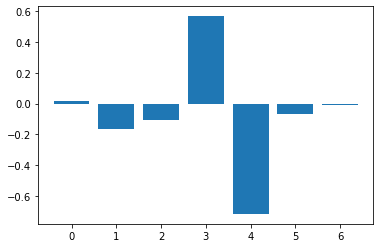

In [ ]:
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()



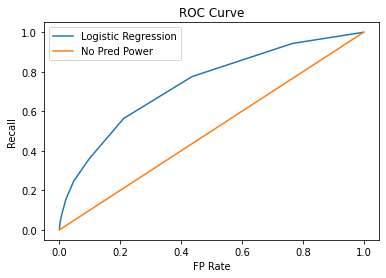

In [ ]:
plt.plot(df["falses"], df["recall"], label = "Logistic Regression")

#plt.plot(df2["falses"], df2["recall"], label = "XGBoost")
plt.plot([0,1],[0,1], label = "No Pred Power")
plt.ylabel("Recall")
plt.xlabel("FP Rate")
plt.title("ROC Curve")
plt.legend()

In [ ]:
#Why ROC curve?
#create a confusion matrix for an optimal threshold.

In [ ]:
df["df"] = np.abs(df.diff()["falses"])
df["df"]=  df["df"].fillna(0)
df

,threshold,accuracy,falses,recall,df
0,0.0,0.139158,1.000000,1.000000,0.000000
1,0.1,0.332834,0.765833,0.943193,0.234167
2,0.2,0.593294,0.436194,0.775710,0.329639
3,0.3,0.757121,0.211685,0.564153,0.224509
4,0.4,0.826087,0.098638,0.360431,0.113046
5,0.5,0.854436,0.047340,0.246817,0.051298
6,0.6,0.863705,0.021691,0.154750,0.025649
7,0.7,0.864795,0.007916,0.077375,0.013775
8,0.8,0.863841,0.002058,0.034280,0.005858
9,0.9,0.861251,0.000633,0.006856,0.001425


In [ ]:
area_under_curve = np.sum(df["recall"]*df["df"])
area_under_curve

0.6618788841547267

#Testing other models

Although the most common algorithms for expected goals are Logistiic Regression and XGBoost, we decided to test other models as well.


In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_prediction_knn = knn.predict(X_train)
print("accuracy:", sklearn.metrics.accuracy_score(y_train, y_prediction_knn))
print("precision:",sklearn.metrics.precision_score(y_train, y_prediction_knn))
print("recall:", sklearn.metrics.recall_score(y_train, y_prediction_knn))
y_prediction_knn_test = knn.predict(X_test)
print(sklearn.metrics.accuracy_score(y_test, y_prediction_knn_test))
print(sklearn.metrics.precision_score(y_test, y_prediction_knn_test))
print(sklearn.metrics.recall_score(y_test, y_prediction_knn_test))
knn_probs = knn.predict_proba(X_train)
knn_probs

NameError: ignored

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
y_prediction_svc = svc.predict(X_train)
print(sklearn.metrics.accuracy_score(y_train, y_prediction_svc))
print(sklearn.metrics.precision_score(y_train, y_prediction_svc))
print(sklearn.metrics.recall_score(y_train, y_prediction_svc))


In [ ]:
#data_dmatrix = xgb.DMatrix(data=X[['aerial_won', 'open_goal', 'Lob', "Volley", 'distance',"dist_to_center","angle", "Other", "nearby_players"]],label=y)
xg = xgb.XGBClassifier(objective = "binary:logistic", learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
xg.fit(X_train,y_train)
y_pred_xgb = xg.predict(X_train)
print(sklearn.metrics.accuracy_score(y_train, y_pred_xgb))
print(sklearn.metrics.precision_score(y_train, y_pred_xgb))
print(sklearn.metrics.recall_score(y_train, y_pred_xgb))

xg.predict_proba(X_train)

In [ ]:
X_train

In [ ]:
#smoothen the parameters
rand_forest = RandomForestClassifier(n_estimators =10, random_state = 42)
rand_forest.fit(X_train, y_train)
y_pred_rf = rand_forest.predict(X_train)
print(sklearn.metrics.accuracy_score(y_train, y_pred_rf))
print(sklearn.metrics.precision_score(y_train, y_pred_rf))
print(sklearn.metrics.recall_score(y_train, y_pred_rf))
y_pred_rf_test = rand_forest.predict(X_test)
print(sklearn.metrics.accuracy_score(y_test, y_pred_rf_test))
print(sklearn.metrics.precision_score(y_test, y_pred_rf_test))
print(sklearn.metrics.recall_score(y_test, y_pred_rf_test))


In [ ]:
#smoothen the parameters using l1/l2 regularization
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_train)
print(sklearn.metrics.accuracy_score(y_train, y_pred_rf))
print(sklearn.metrics.precision_score(y_train, y_pred_rf))
print(sklearn.metrics.recall_score(y_train, y_pred_rf))
y_pred_dt_test = dt_model.predict(X_test)
print(sklearn.metrics.accuracy_score(y_test, y_pred_rf_test))
print(sklearn.metrics.precision_score(y_test, y_pred_rf_test))
print(sklearn.metrics.recall_score(y_test, y_pred_rf_test))
dt_model.predict_proba(X_test)
